In [2]:
import pandas as pd
results_dir = '/home/eva/0_point_mutation/benchmark_results/playground_mAb_DMS/results/'
ablang_csv = pd.read_csv(results_dir + 'mab_ablang.csv')
antifold_csv = pd.read_csv(results_dir + 'mab_antifold.csv')
esm1f_csv = pd.read_csv(results_dir + 'mab_esm1f.csv')
pyrosetta_csv = pd.read_csv(results_dir + 'mab_pyrosetta.csv')
experiment_csv = pd.read_csv('/home/eva/0_point_mutation/benchmark_results/playground_mAb_DMS/experiment.csv')

ablang_keep = ablang_csv[["sample","chain", "pos", "wt", "mt","delta_log_likelihood_ablang"]]
antifold_keep = antifold_csv[["sample","chain", "pos", "wt", "mt","delta_log_likelihood_antifold"]]
esm1f_keep = esm1f_csv[["sample","chain", "pos", "wt", "mt","delta_log_likelihood_esm1f"]]
pyrosetta_keep = pyrosetta_csv[["sample","chain", "pos", "wt", "mt","delta_log_likelihood_pyrosetta"]]
experiment_keep = experiment_csv[["chain", "pos", "wt", "mt","score_experiment"]]

# Merge all dataframes on sample, chain, pos, wt, mt
merged_df = ablang_keep.merge(antifold_keep, on=["sample","chain","pos","wt","mt"], how="outer")
merged_df = merged_df.merge(esm1f_keep, on=["sample","chain","pos","wt","mt"], how="outer")
merged_df = merged_df.merge(pyrosetta_keep, on=["sample","chain","pos","wt","mt"], how="outer")

# Fill all NA values with 0
merged_df = merged_df.fillna("0")

merged_df = merged_df.merge(experiment_keep, on=["chain", "pos", "wt", "mt"], how="outer")
merged_df = merged_df.fillna("Na")

# sort values
merged_df = merged_df.sort_values(by=["sample", "chain", "pos", "wt", "mt"]).reset_index(drop=True)


,delta_log_likelihood_ablang,delta_log_likelihood_antifold,delta_log_likelihood_esm1f,delta_log_likelihood_pyrosetta,score_experiment
delta_log_likelihood_ablang,1.000000,0.645757,0.383567,0.164152,0.459065
delta_log_likelihood_antifold,0.645757,1.000000,0.736045,0.309333,0.486760
delta_log_likelihood_esm1f,0.383567,0.736045,1.000000,0.382364,0.398159
delta_log_likelihood_pyrosetta,0.164152,0.309333,0.382364,1.000000,0.152629
score_experiment,0.459065,0.486760,0.398159,0.152629,1.000000


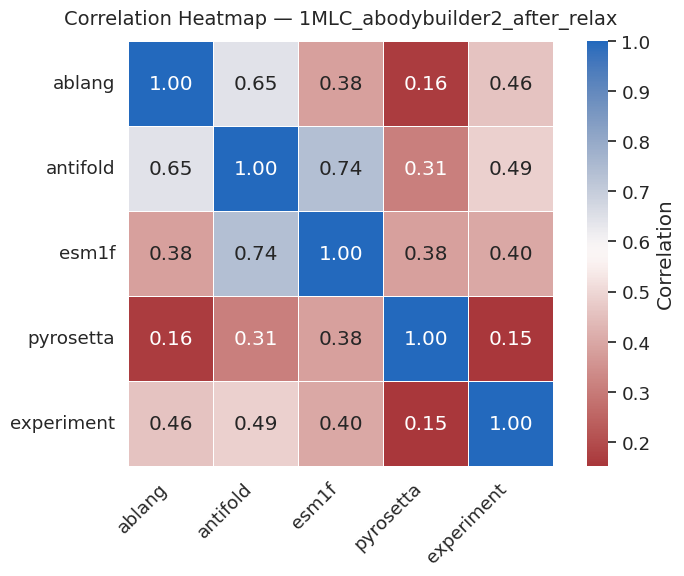

,delta_log_likelihood_ablang,delta_log_likelihood_antifold,delta_log_likelihood_esm1f,delta_log_likelihood_pyrosetta,score_experiment
delta_log_likelihood_ablang,1.000000,0.646745,0.406358,0.161959,0.459065
delta_log_likelihood_antifold,0.646745,1.000000,0.749739,0.293103,0.480913
delta_log_likelihood_esm1f,0.406358,0.749739,1.000000,0.374232,0.392414
delta_log_likelihood_pyrosetta,0.161959,0.293103,0.374232,1.000000,0.157267
score_experiment,0.459065,0.480913,0.392414,0.157267,1.000000


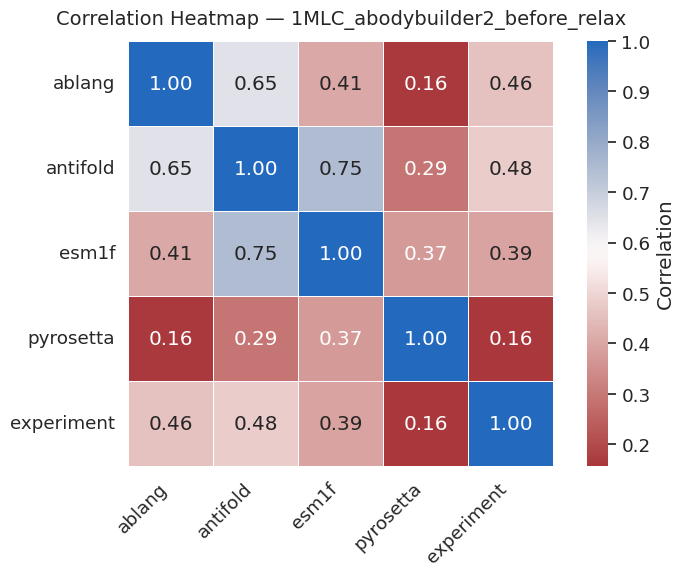

,delta_log_likelihood_ablang,delta_log_likelihood_antifold,delta_log_likelihood_esm1f,delta_log_likelihood_pyrosetta,score_experiment
delta_log_likelihood_ablang,1.000000,0.548537,0.383336,0.175296,0.459065
delta_log_likelihood_antifold,0.548537,1.000000,0.756303,0.357443,0.435606
delta_log_likelihood_esm1f,0.383336,0.756303,1.000000,0.398226,0.414913
delta_log_likelihood_pyrosetta,0.175296,0.357443,0.398226,1.000000,0.180121
score_experiment,0.459065,0.435606,0.414913,0.180121,1.000000


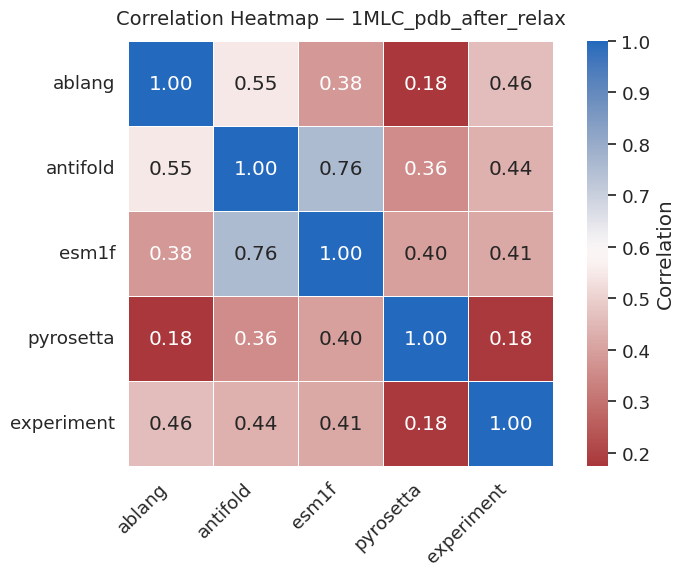

,delta_log_likelihood_ablang,delta_log_likelihood_antifold,delta_log_likelihood_esm1f,delta_log_likelihood_pyrosetta,score_experiment
delta_log_likelihood_ablang,1.000000,0.567615,0.398517,0.169658,0.459065
delta_log_likelihood_antifold,0.567615,1.000000,0.754191,0.291374,0.463746
delta_log_likelihood_esm1f,0.398517,0.754191,1.000000,0.318416,0.424271
delta_log_likelihood_pyrosetta,0.169658,0.291374,0.318416,1.000000,0.163103
score_experiment,0.459065,0.463746,0.424271,0.163103,1.000000


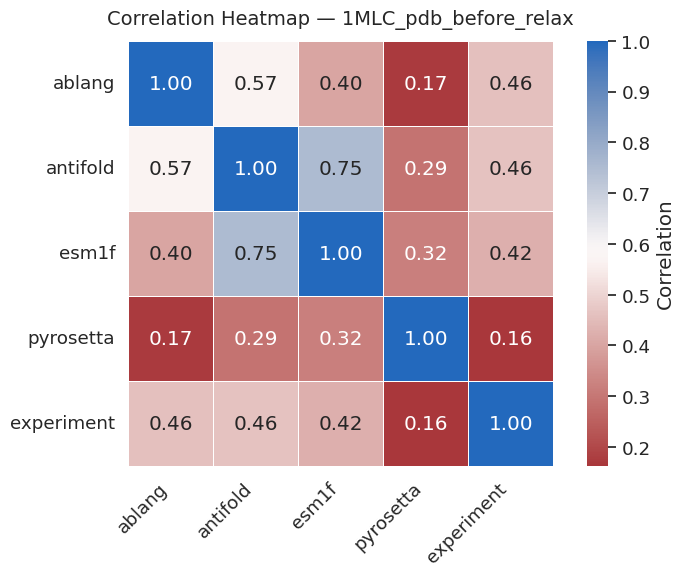

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Filter numeric scoring columns
score_columns = [col for col in merged_df.columns if col.startswith("delta") or col.startswith("score")]

# Step 2: Clean invalid values
merged_df = merged_df[merged_df['score_experiment'] != "Na"]
merged_df['score_experiment'] = merged_df['score_experiment'].astype(float) * (-1)
merged_df[score_columns] = merged_df[score_columns].apply(pd.to_numeric, errors='coerce')

# Step 3: Loop over each sample
samples = merged_df["sample"].unique()

# Use a modern Seaborn theme
sns.set_theme(style="whitegrid", font_scale=1.2)

for sample in samples:
    sample_df = merged_df[merged_df["sample"] == sample][score_columns]

    if sample_df.shape[0] < 2:
        continue

    corr = sample_df.corr()
    display(corr)

    # Abbreviate column names: get last part after "_" (e.g. 'pyrosetta' from 'delta_log_likelihood_pyrosetta')
    abbrev = {col: col.split("_")[-1] for col in corr.columns}
    corr.rename(columns=abbrev, index=abbrev, inplace=True)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        corr,
        annot=True, #display numeric value
        fmt=".2f", #format to .2 decimal places
        cmap="vlag_r", 
        linewidths=0.5,#draw gridline between cell with 0.5
        linecolor="white",
        square=True, #keep each cell square
        cbar_kws={"label": "Correlation"},#add label to the color bar
    )

    plt.title(f"Correlation Heatmap — {sample}", fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

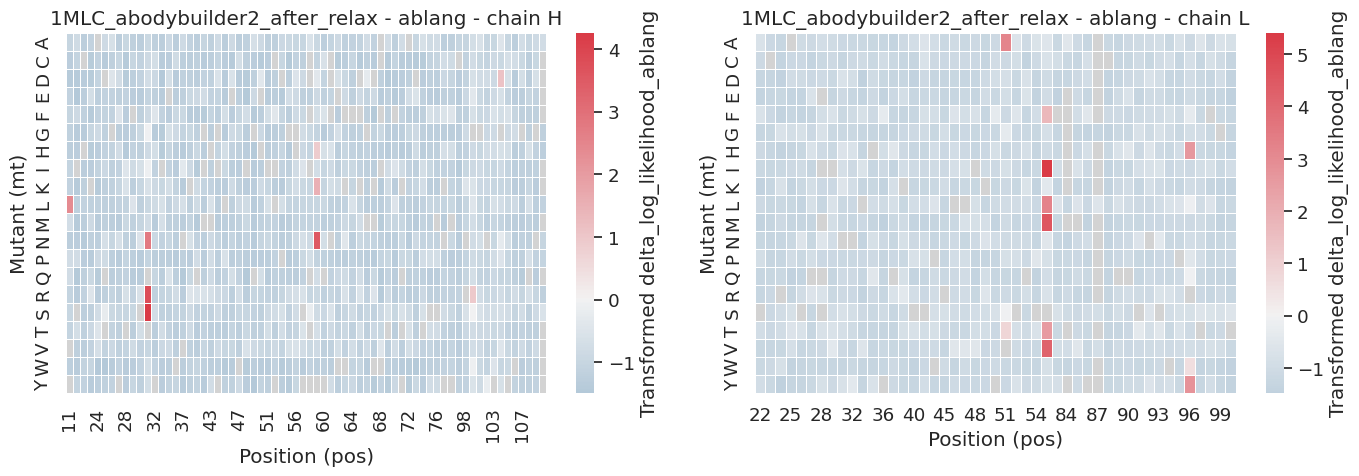

/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

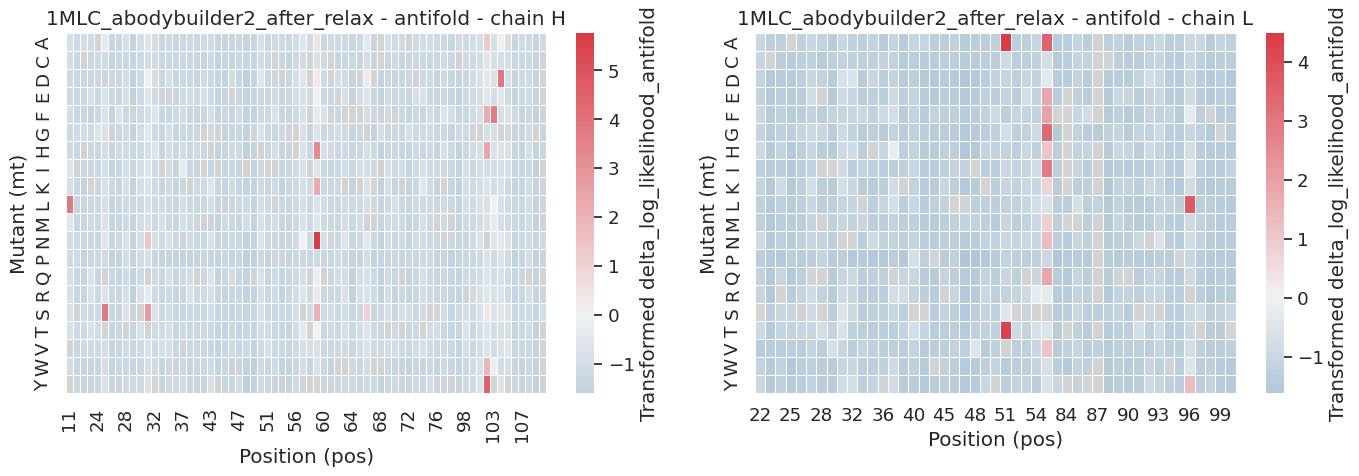

/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

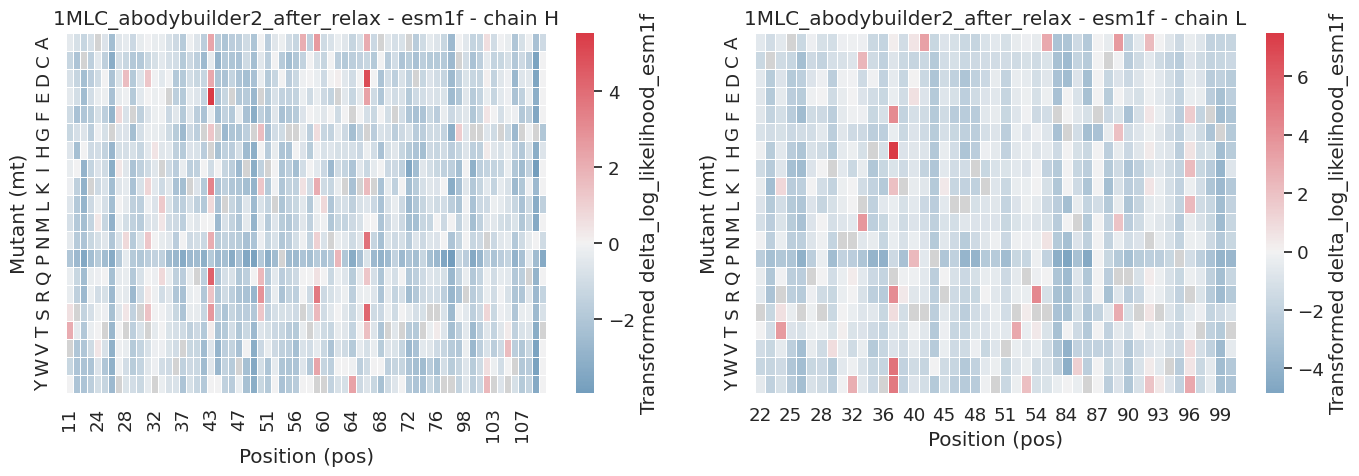

/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

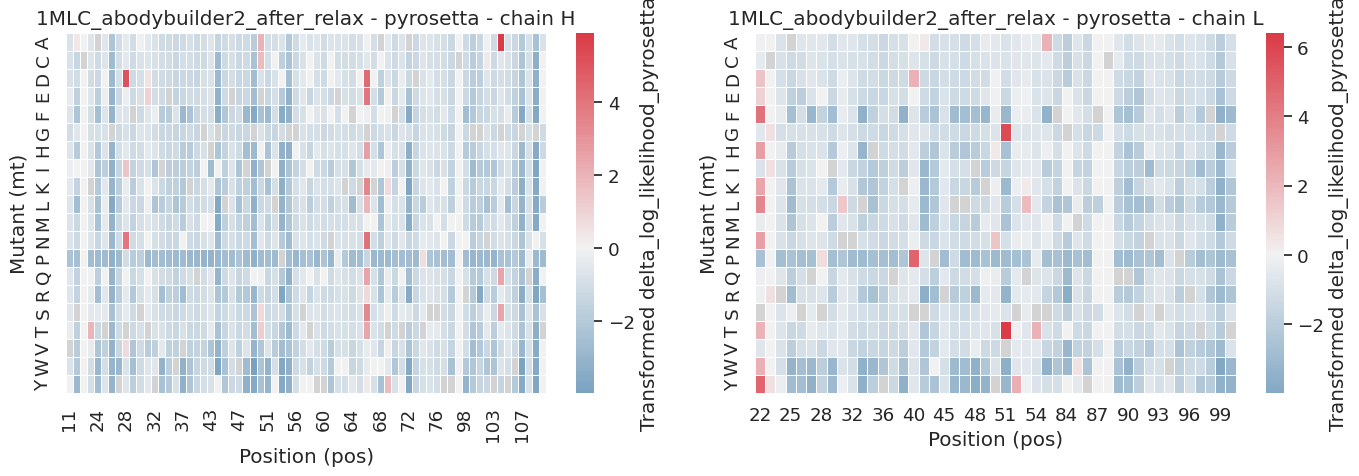

/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)


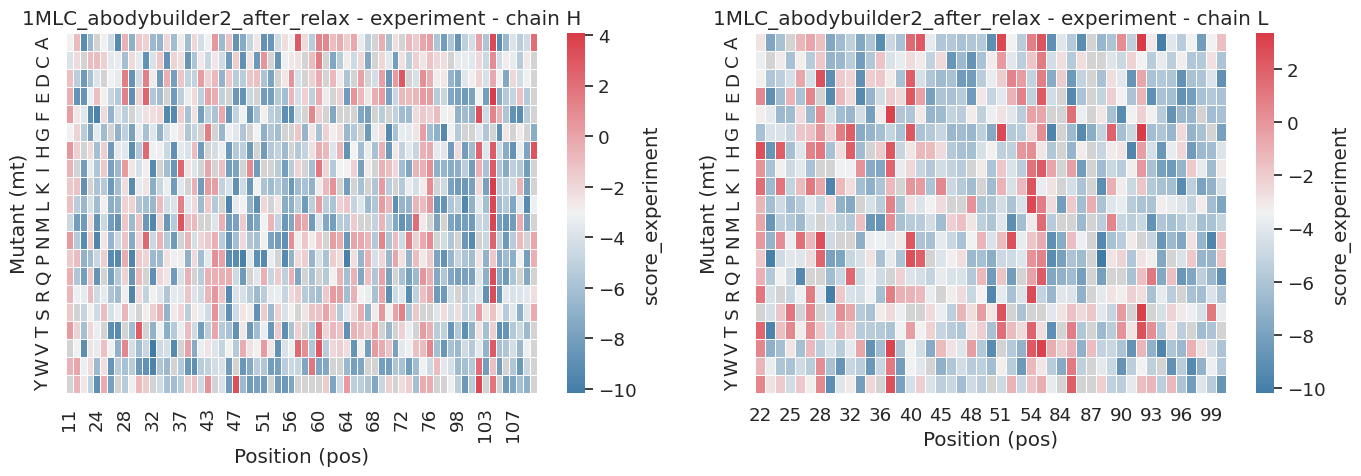

/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

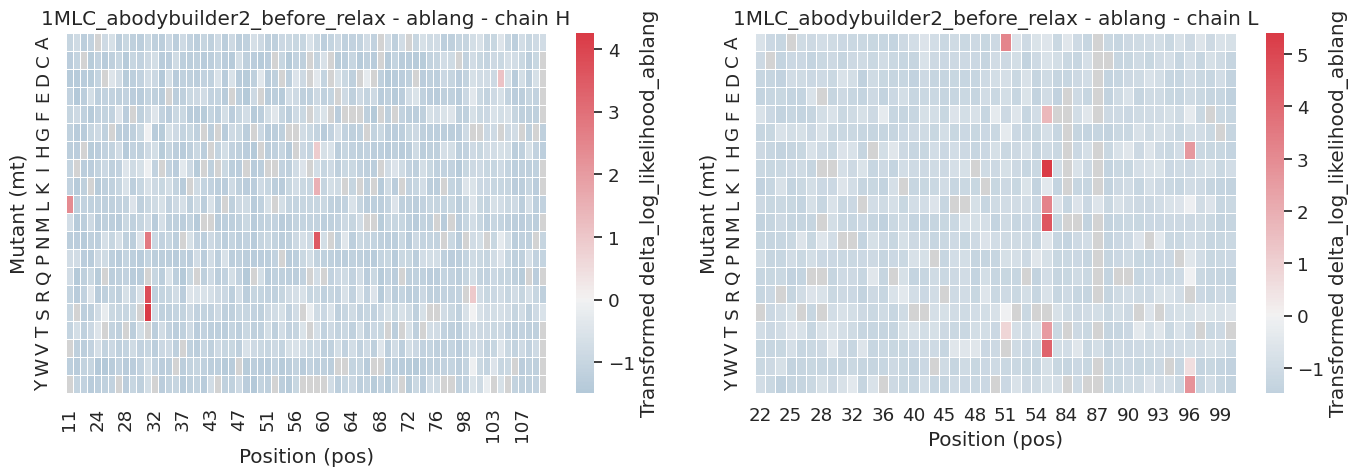

/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

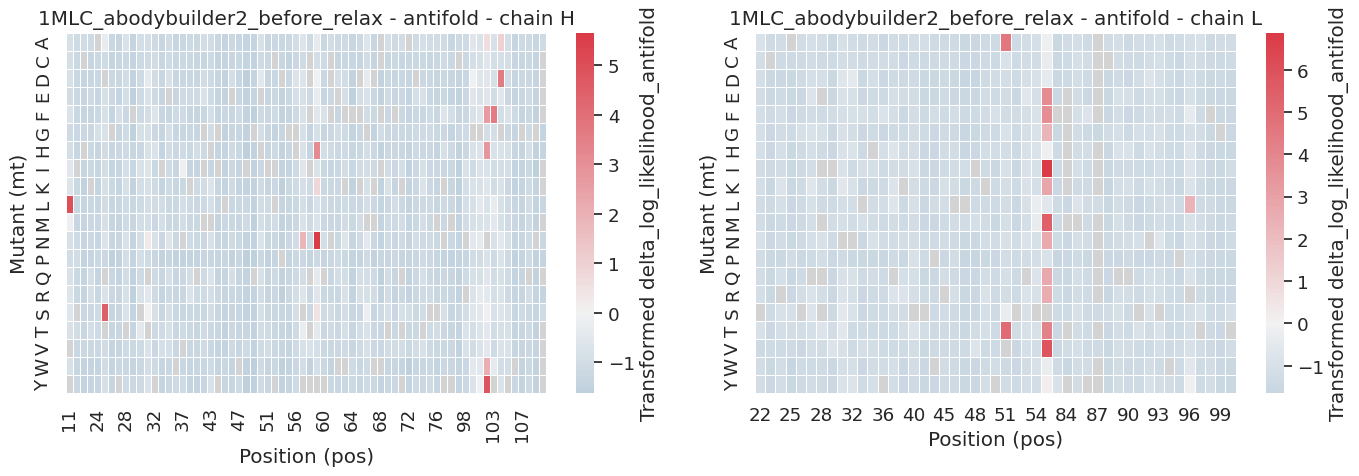

/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

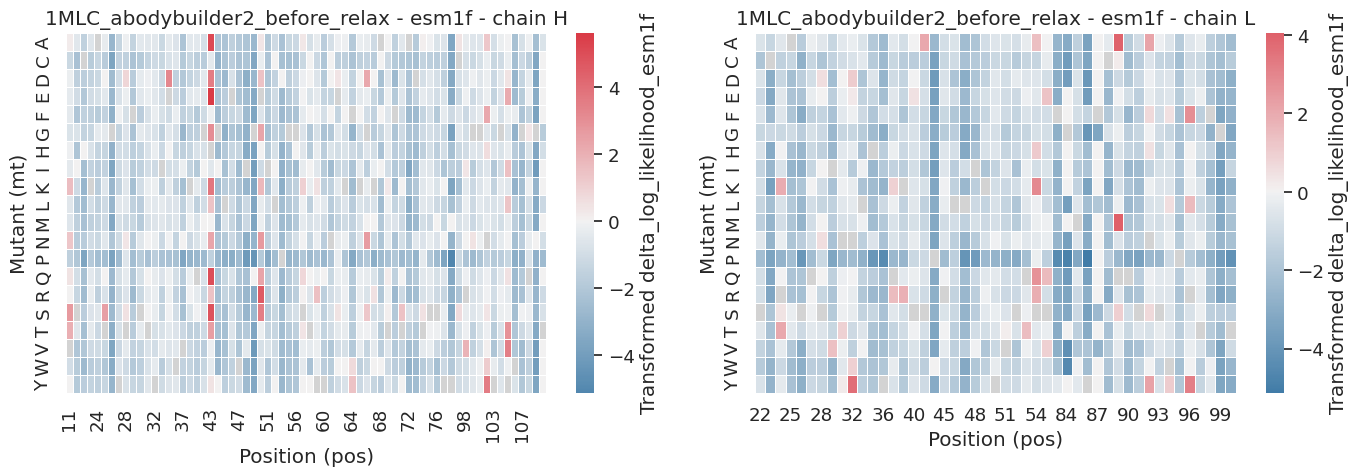

/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

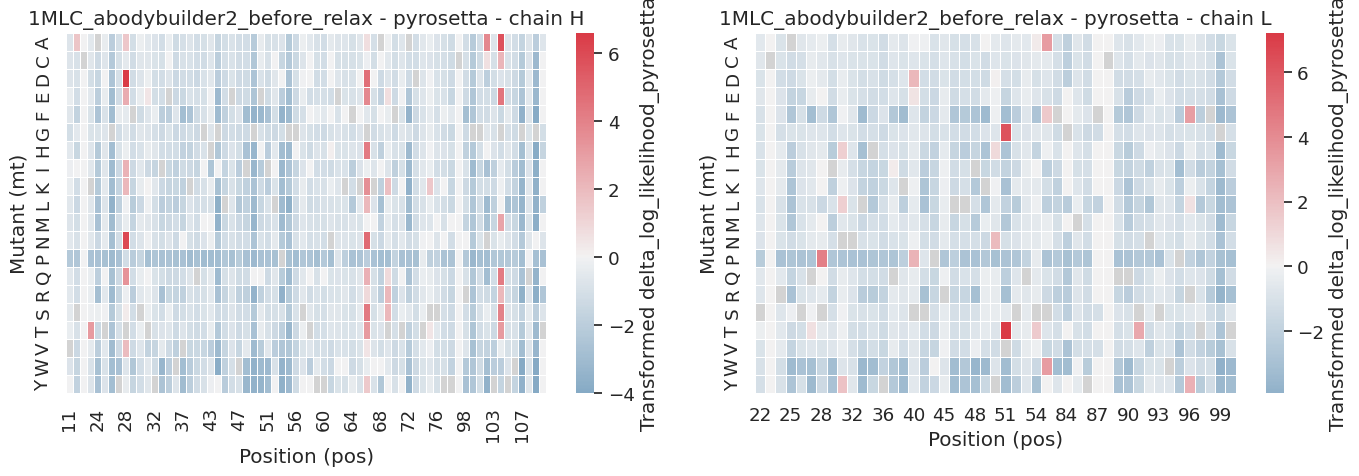

/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)


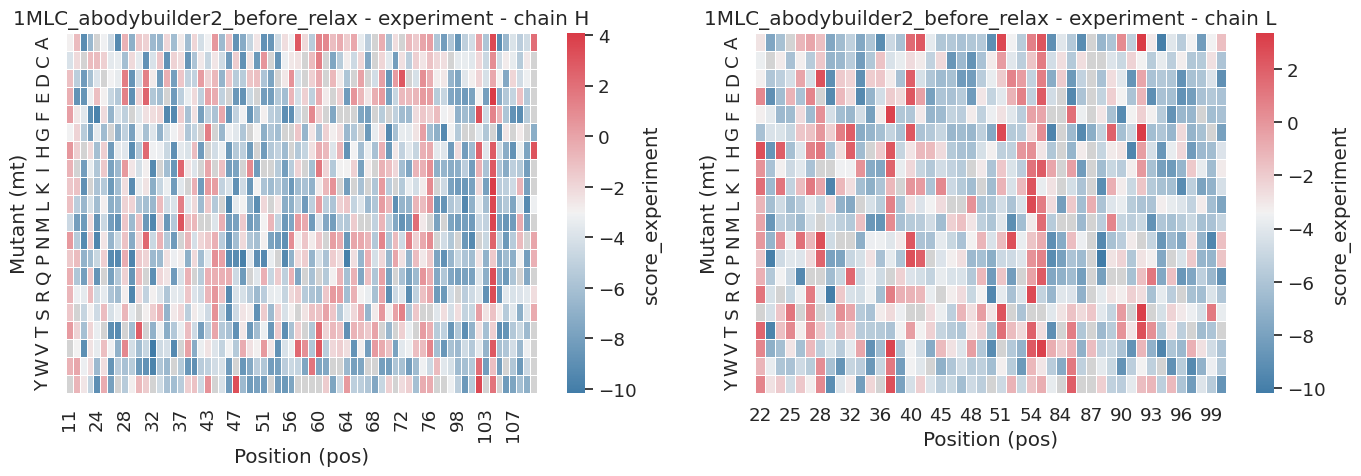

/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

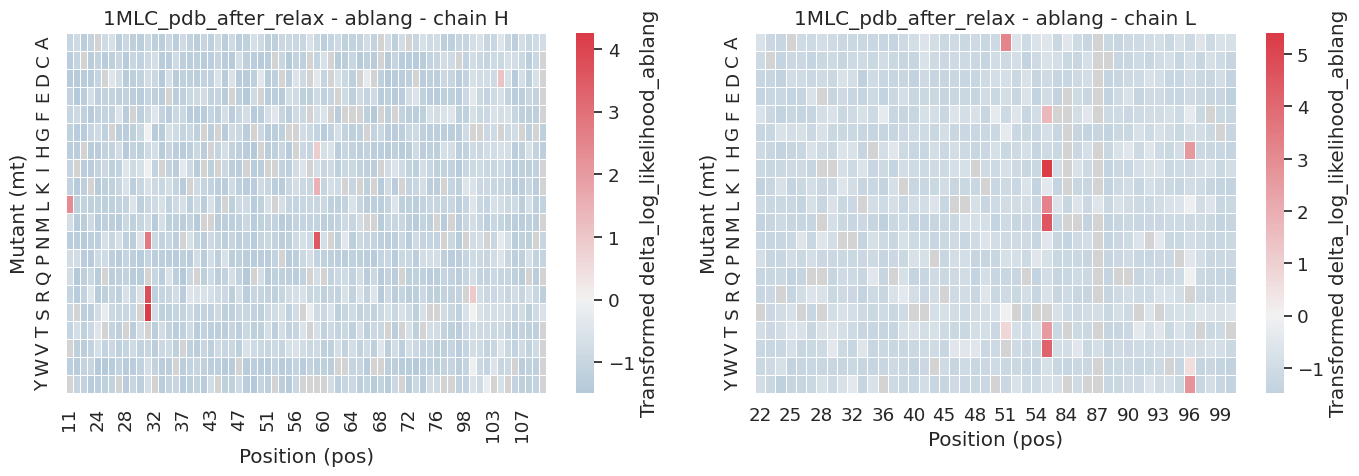

/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

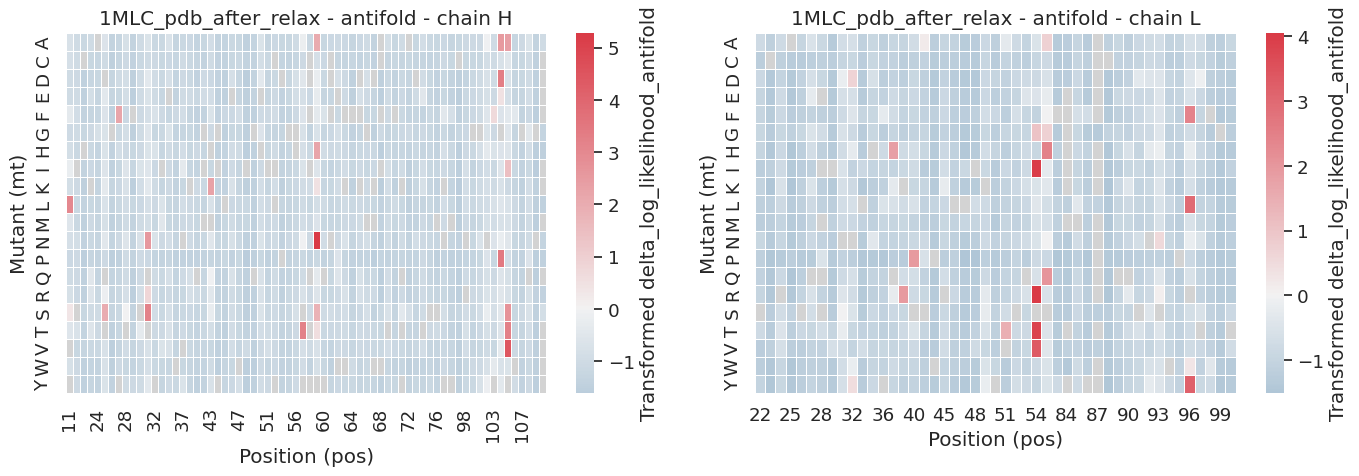

/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

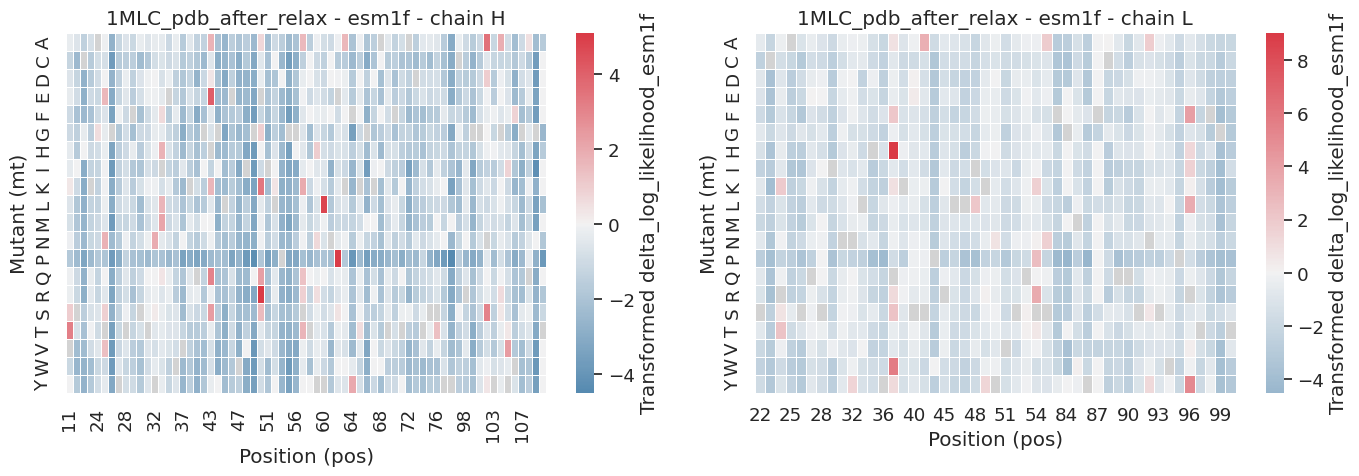

/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

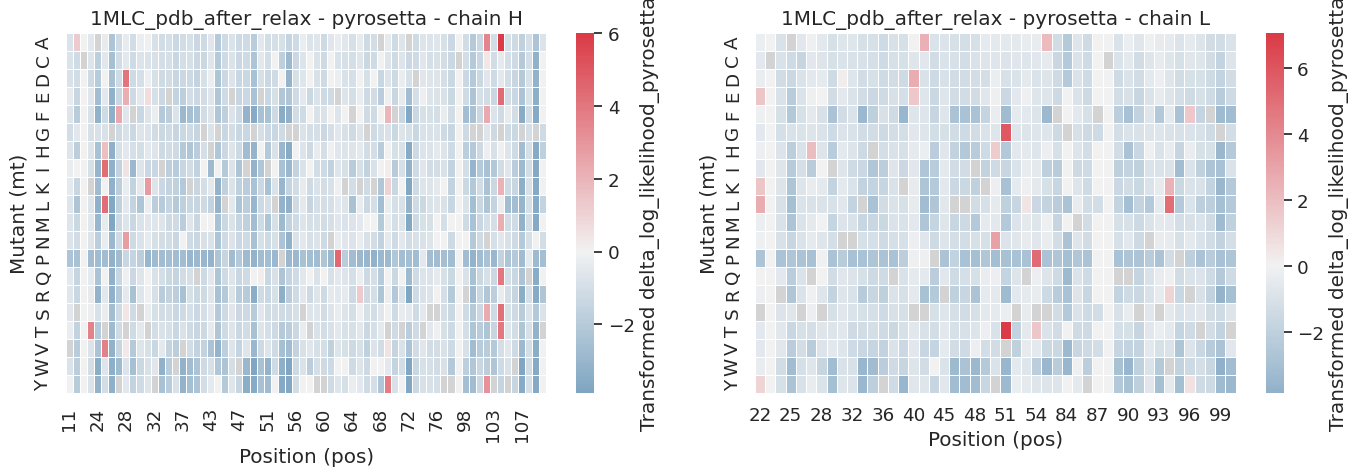

/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)


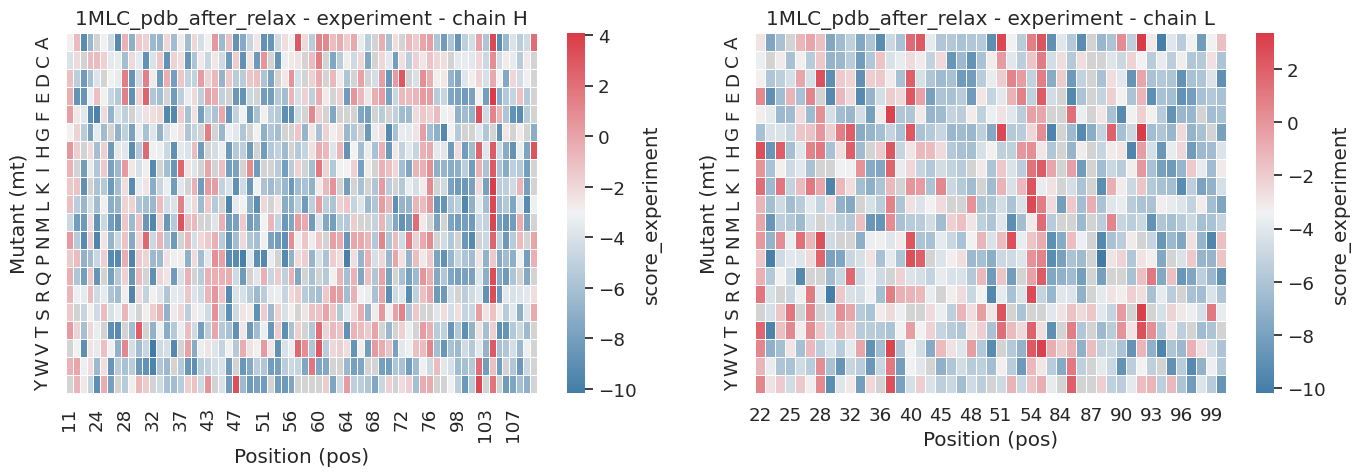

/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

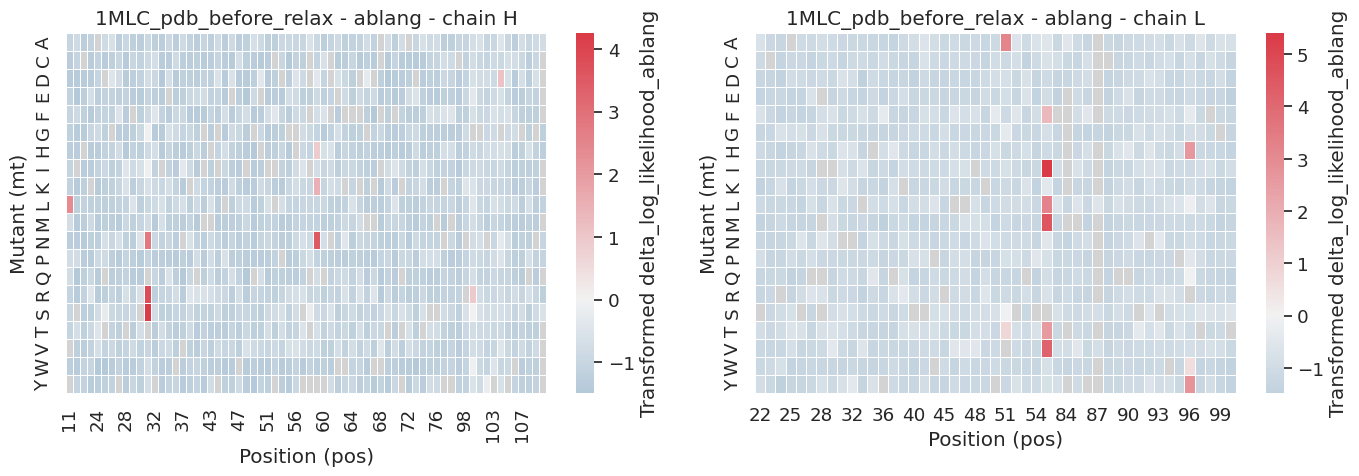

/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_default)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

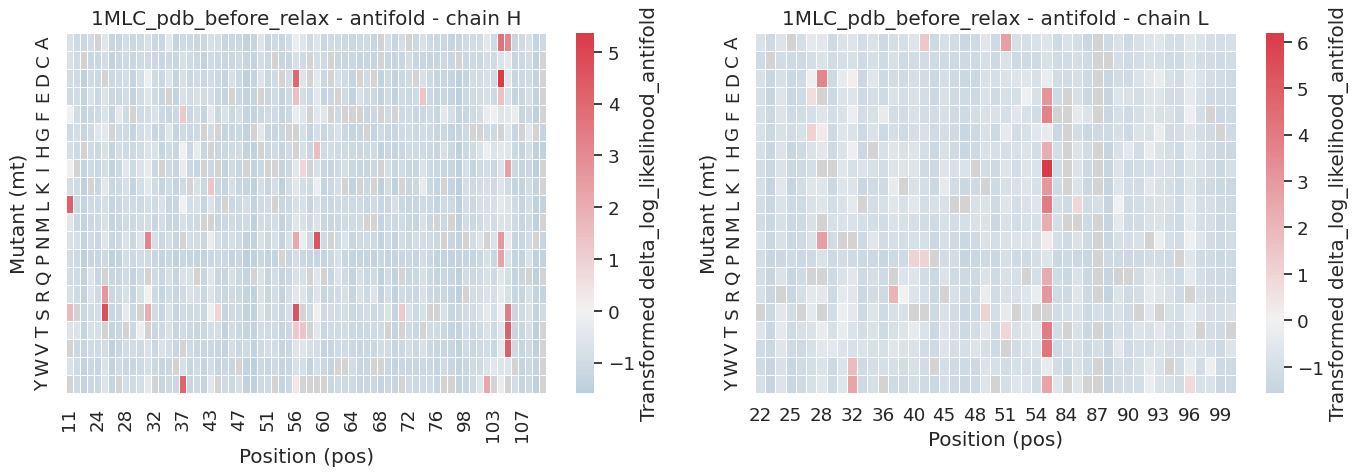

/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_esm1f)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

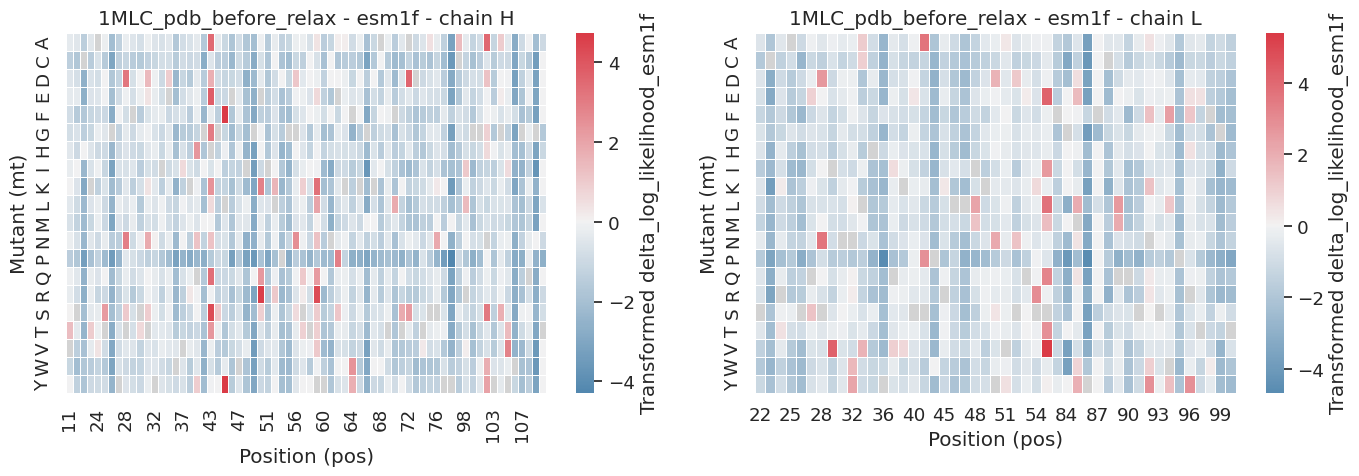

/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_transformed = pivot.applymap(signed_log_pyrosetta)
/tmp/ipykernel_2425/3820355732.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

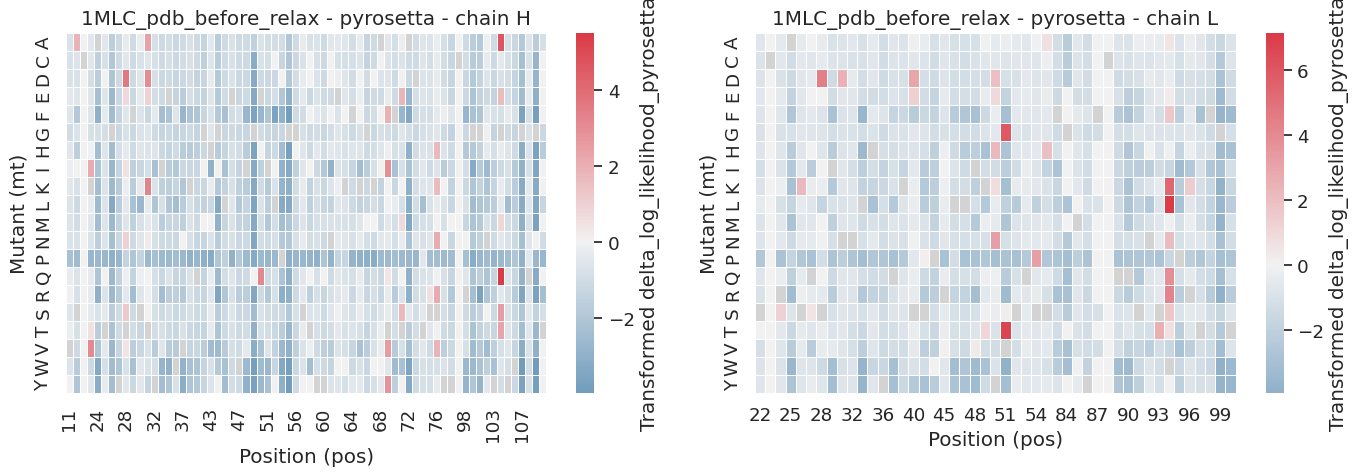

/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)
/tmp/ipykernel_2425/3820355732.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask = mask_matrix.notna().reindex_like(pivot).fillna(False)


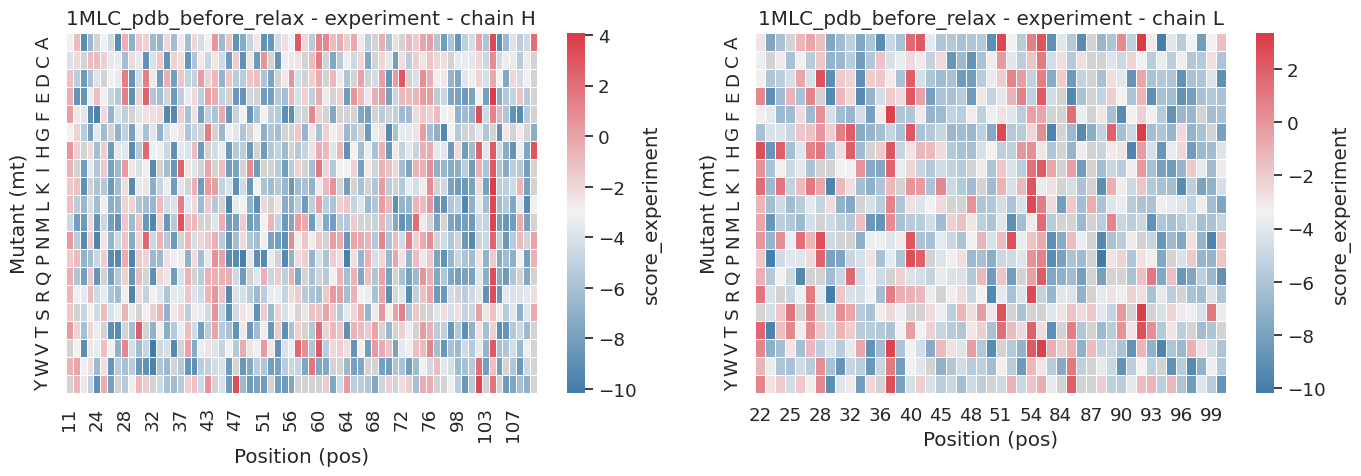

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Use your merged dataframe
df = merged_df.copy()

# Identify delta and score columns
delta_cols = [col for col in df.columns if col.startswith("delta")]
score_cols = [col for col in df.columns if col.startswith("score")]
samples = df['sample'].unique()

# Ensure numeric conversion
for col in delta_cols + score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Custom signed log transforms
def signed_log_default(x):
    try:
        val = np.sign(x) * np.log1p(np.abs(x))
        return val * 3 if x > 0 else val * 0.5
    except:
        return np.nan

def signed_log_esm1f(x):
    try:
        val = np.sign(x) * np.log1p(np.abs(x))
        if x > 0:
            return val * 300
        elif x < 0:
            return val * 50
        else:
            return 0
    except:
        return np.nan

def signed_log_pyrosetta(x):
    try:
        val = np.sign(x) * np.log1p(np.abs(x))
        if x > 0:
            return np.log1p(x) * 4
        elif x < 0:
            return val * 0.5
        else:
            return 0
    except:
        return np.nan

# Define diverging cmap (with meaningful 0 as sperator) with grey mask
def get_diverging_cmap():
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    cmap.set_bad("lightgrey") #Nan or masked value 
    return cmap

# Iterate through samples
for sample in samples:
    df_sample = df[df['sample'] == sample]

    # === Plot delta columns (with transform) ===
    for delta_col in delta_cols:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        for j, chain_type in enumerate(['H', 'L']):
            df_chain = df_sample[df_sample['chain'] == chain_type]
            pivot = df_chain.pivot(index="mt", columns="pos", values=delta_col).astype(float)

            # Apply appropriate transform
            if delta_col == "delta_log_likelihood_esm1f":
                pivot_transformed = pivot.applymap(signed_log_esm1f)
            elif delta_col == "delta_log_likelihood_pyrosetta":
                pivot_transformed = pivot.applymap(signed_log_pyrosetta)
            else:
                pivot_transformed = pivot.applymap(signed_log_default)

            # Mask where wt == mt
            mask_data = df_chain[df_chain['wt'] == df_chain['mt']]
            mask_matrix = mask_data.pivot(index="mt", columns="pos", values=delta_col)
            # Can omit to follow line if mask_matrix and pivot_transformed have
            # the same shape and clean table(no Na)
            mask = mask_matrix.notna().reindex_like(pivot).fillna(False)

            sns.heatmap(
                pivot_transformed,
                mask=mask,
                cmap=get_diverging_cmap(),
                center=0,
                linewidths=0.5,
                cbar_kws={"label": f"Transformed {delta_col}"},
                ax=axs[j]
            )
            method_name = delta_col.split("_")[-1]
            axs[j].set_title(f"{sample} - {method_name} - chain {chain_type}")
            axs[j].set_ylabel("Mutant (mt)")
            axs[j].set_xlabel("Position (pos)")

        plt.tight_layout()
        plt.show()

    # === Plot score columns (no transform) ===
    for score_col in score_cols:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        for j, chain_type in enumerate(['H', 'L']):
            df_chain = df_sample[df_sample['chain'] == chain_type]
            pivot = df_chain.pivot(index="mt", columns="pos", values=score_col).astype(float)

            # Mask where wt == mt
            mask_data = df_chain[df_chain['wt'] == df_chain['mt']]
            mask_matrix = mask_data.pivot(index="mt", columns="pos", values=score_col)
            mask = mask_matrix.notna().reindex_like(pivot).fillna(False)

            sns.heatmap(
                pivot,
                mask=mask,
                cmap=get_diverging_cmap(),
                linewidths=0.5,
                cbar_kws={"label": score_col},
                ax=axs[j]
            )
            method_name = score_col.split("_")[-1]
            axs[j].set_title(f"{sample} - {method_name} - chain {chain_type}")
            axs[j].set_ylabel("Mutant (mt)")
            axs[j].set_xlabel("Position (pos)")

        plt.tight_layout()
        plt.show()


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Copy merged dataframe ===
df = merged_df.copy()
df

,sample,chain,pos,wt,mt,delta_log_likelihood_ablang,delta_log_likelihood_antifold,delta_log_likelihood_esm1f,delta_log_likelihood_pyrosetta,score_experiment
200,1MLC_abodybuilder2_after_relax,H,11,V,A,-7.052836,-5.4219,-0.008130,-3.614579,-2.937981e+00
201,1MLC_abodybuilder2_after_relax,H,11,V,C,-12.757563,-6.4366,-0.026199,-3.810010,-4.039682e+00
202,1MLC_abodybuilder2_after_relax,H,11,V,D,-15.070385,-7.7195,-0.015806,-4.424121,-1.091000e+00
203,1MLC_abodybuilder2_after_relax,H,11,V,E,-8.510320,-7.4382,-0.008127,-0.934889,-4.410168e-01
204,1MLC_abodybuilder2_after_relax,H,11,V,F,-6.994947,-5.7824,-0.021059,-2.785989,1.925652e-01
...,...,...,...,...,...,...,...,...,...,...
17735,1MLC_pdb_before_relax,L,102,T,S,-2.400477,-4.8353,-0.019952,-3.317779,-3.766897e+00
17736,1MLC_pdb_before_relax,L,102,T,T,0.000000,0.0000,0.000000,0.000000,5.539735e-07
17737,1MLC_pdb_before_relax,L,102,T,V,-9.976730,-3.1826,-0.014493,-3.737465,-6.059814e+00
17738,1MLC_pdb_before_relax,L,102,T,W,-17.470378,-11.9655,-0.041579,-951.414797,-5.795144e+00


/tmp/ipykernel_2425/4017228263.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_transformed[delta_cols] = df_transformed[delta_cols].applymap(lambda x: x if x > 0 else 0)


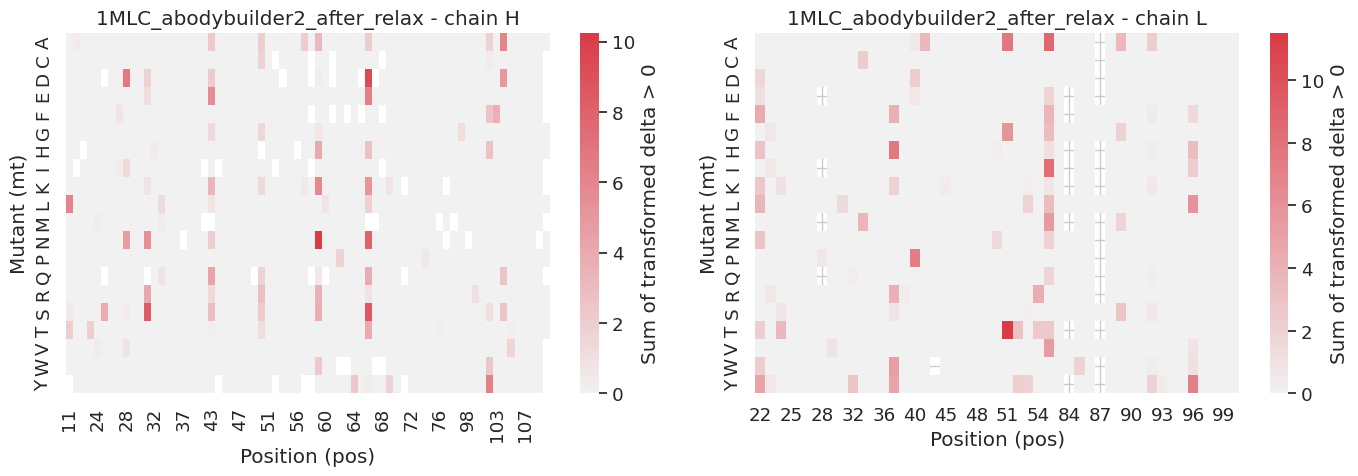

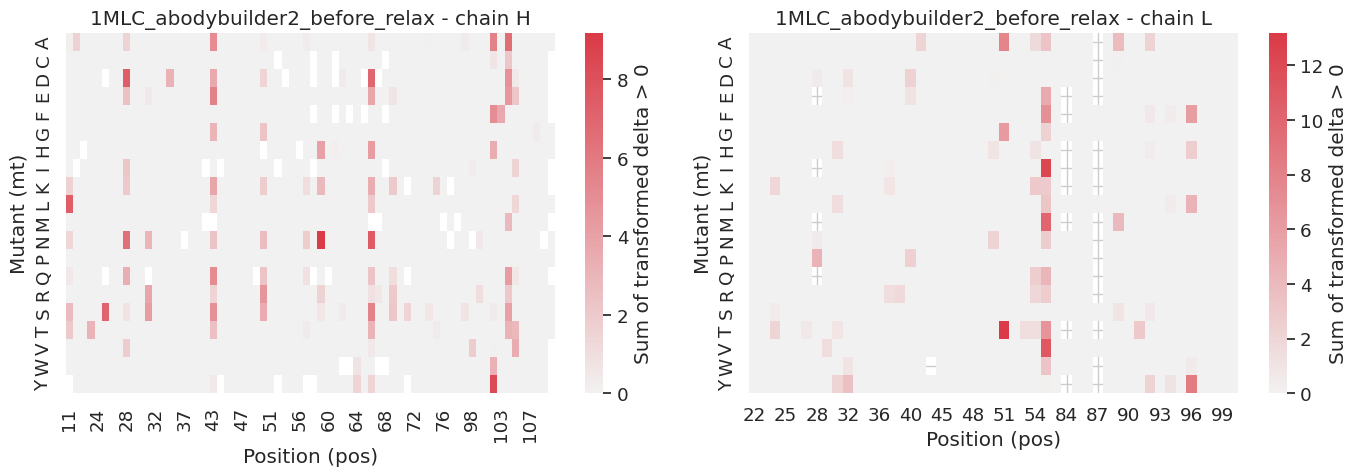

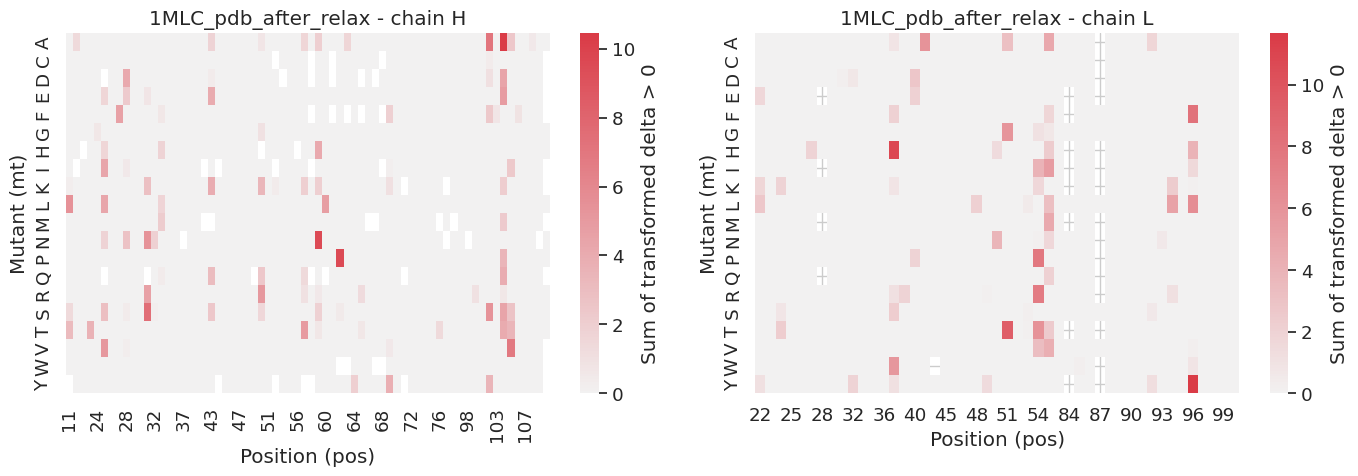

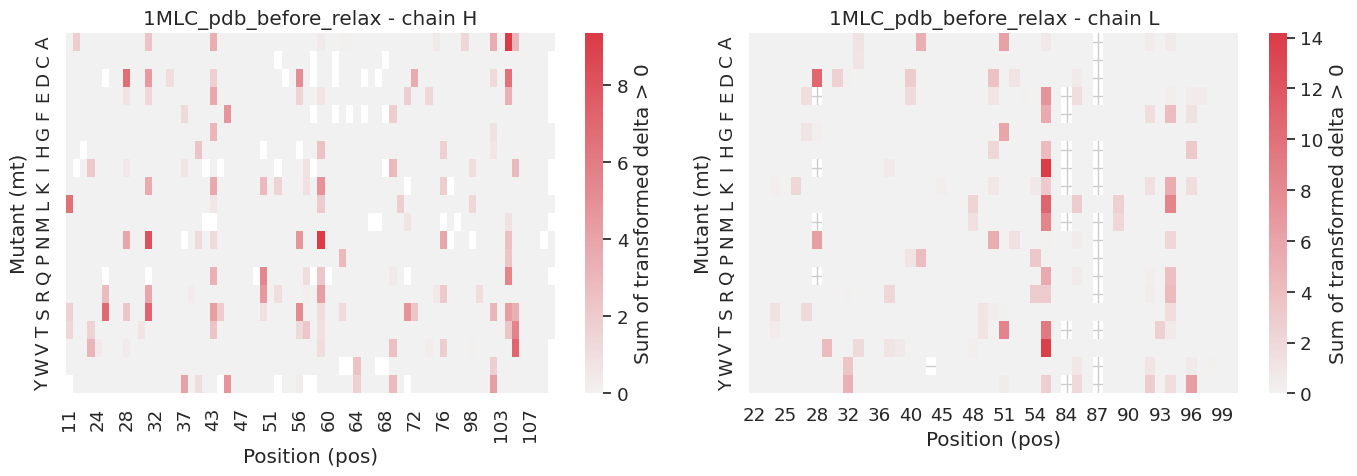